# 💾 Data

The FER-2013 dataset consists of 48x48 pixel grayscale images of faces that have been automatically registered to be centred and occupy a similar amount of space in each image. The dataset contains 24,400 images, with 22,968 examples in the training set and 1,432 examples in the public test set.

# 🛠 Preprocessing

In this section, we will be using both data generators and data augmentation to train a deep learning model for human emotion detection using the FER-2013 dataset. Due to the size and complexity of the dataset, it would be impractical to load all of the images into memory at once. Therefore, we will be using data generators to generate batches of images on-the-fly during training, which will allow us to efficiently train our model on the entire dataset.

In addition, we will be applying various data augmentation techniques to the training images, such as rotation, shifting, and flipping. This will help to increase the size and diversity of our training set, which can improve the performance of our deep learning model. By introducing variability into the training process, data augmentation can also help to prevent overfitting, which occurs when the model becomes too closely tailored to the training set and performs poorly on new, unseen data.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_dir = "../input/fer2013/train" # Directory containing the training data
test_dir = "../input/fer2013/test"  # Directory containing the validation data

In [9]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# Modeling 

## CNN Model

To develop the CNN architecture, we will begin by defining the input layer and the number of filters in the first convolutional layer. Then, we will add additional convolutional layers with increasing numbers of filters, followed by max-pooling layers to reduce the spatial dimensions of the feature maps. After the convolutional layers, we will add fully connected layers with ReLU activation to classify the emotions.

We will experiment with different numbers of convolutional layers, filter sizes, and fully connected layers to optimize the model performance. Additionally, we will use techniques such as dropout and batch normalization to prevent overfitting and improve the generalization capability of the model.

In [11]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from keras.layers import BatchNormalization


model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [12]:

checkpoint_callback = ModelCheckpoint(
    filepath='emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator, callbacks=[early_stopping])
# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback]
)

Epoch 1/50
359/359 [==============================] - ETA: 0s - loss: 2.2073 - accuracy: 0.2321
Epoch 1: val_accuracy improved from -inf to 0.26885, saving model to emotion_model.h5
359/359 [==============================] - 365s 1s/step - loss: 2.2073 - accuracy: 0.2321 - val_loss: 1.8516 - val_accuracy: 0.2689
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 1.6949 - accuracy: 0.3546
Epoch 2: val_accuracy improved from 0.26885 to 0.41830, saving model to emotion_model.h5
359/359 [==============================] - 355s 988ms/step - loss: 1.6949 - accuracy: 0.3546 - val_loss: 1.4950 - val_accuracy: 0.4183
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 1.4855 - accuracy: 0.4313
Epoch 3: val_accuracy improved from 0.41830 to 0.44204, saving model to emotion_model.h5
359/359 [==============================] - 351s 977ms/step - loss: 1.4855 - accuracy: 0.4313 - val_loss: 1.4954 - val_accuracy: 0.4420
Epoch 4/50
359/359 [==========================

## Evaluation

### Training and validation loss curves

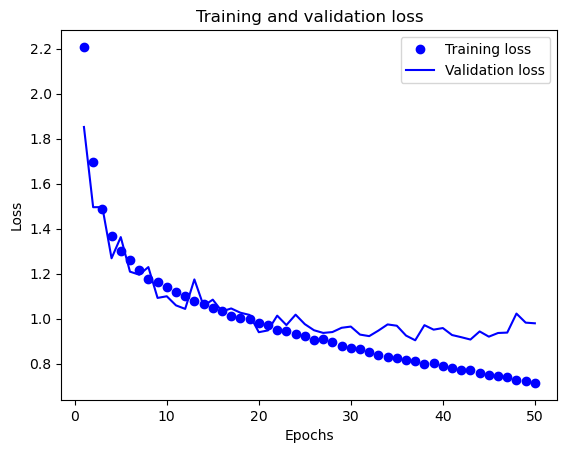

In [13]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training and validation accuracy curves

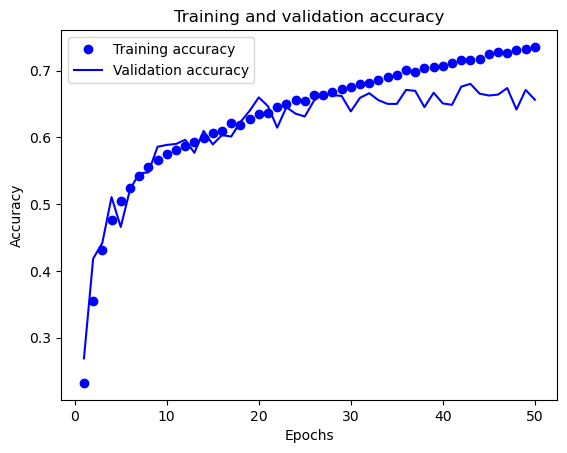

In [14]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix

23/23 [==============================] - 5s 200ms/step


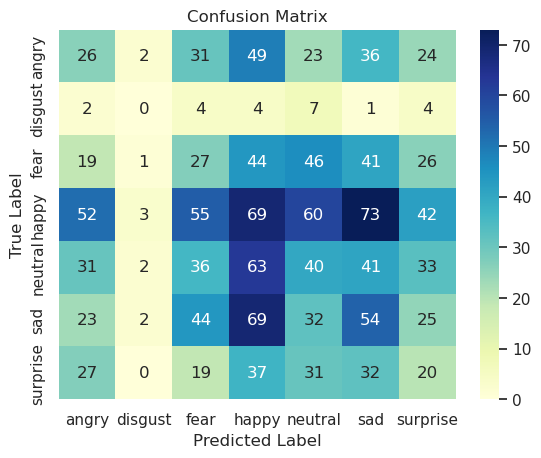

In [15]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from keras.preprocessing import image
img = image.load_img("/kaggle/input/testimage",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)